In [6]:
import pandas as pd
import numpy as np
import os
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

def load_all_datasets_fixed(base_path):
    datasets = {}
    
    # Standard mapping
    experiments = {
        'Set1': '1st_test',
        'Set2': '2nd_test',
        'Set3': '3rd_test' 
    }
    
    print(f"🚀 Starting Final Data Ingestion from: {base_path}\n")
    
    for set_name, folder_name in experiments.items():
        # 1. Base path construction
        current_path = os.path.join(base_path, folder_name)
        
        # 2. Handle "Double Folder" (e.g. 1st_test/1st_test)
        if os.path.exists(os.path.join(current_path, folder_name)):
            current_path = os.path.join(current_path, folder_name)
        # Handle Set 3 quirk (it's often named 4th_test inside 3rd_test)
        elif os.path.exists(os.path.join(current_path, "4th_test")):
             current_path = os.path.join(current_path, "4th_test")

        # 3. CRITICAL FIX: Handle the 'txt' folder inside Set 3
        if os.path.exists(os.path.join(current_path, "txt")):
            current_path = os.path.join(current_path, "txt")
            
        print(f"📂 Processing {set_name}...")
        print(f"   -> Targeted Path: {current_path}")
        
        if not os.path.exists(current_path):
             print(f"   ❌ Path does not exist. Skipping.")
             continue

        data_list = []
        filenames = sorted(os.listdir(current_path))
        
        for filename in filenames:
            if os.path.isdir(os.path.join(current_path, filename)): continue
            
            try:
                # Read file
                df_raw = pd.read_csv(os.path.join(current_path, filename), sep='\t', header=None)
                
                snapshot_stats = {'timestamp': filename, 'dataset': set_name}
                
                # --- UNIVERSAL MAPPING ---
                if set_name == 'Set1':
                    # Set 1 (8 cols) -> Use Cols 0, 2, 4, 6
                    bearings_map = {'B1': df_raw[0], 'B2': df_raw[2], 'B3': df_raw[4], 'B4': df_raw[6]}
                else:
                    # Set 2 & 3 (4 cols) -> Use Cols 0, 1, 2, 3
                    bearings_map = {'B1': df_raw[0], 'B2': df_raw[1], 'B3': df_raw[2], 'B4': df_raw[3]}
                
                # --- FEATURES ---
                for b_name, signal in bearings_map.items():
                    abs_signal = np.abs(signal)
                    rms = np.sqrt(np.mean(signal**2))
                    kurt = kurtosis(signal)
                    skw = skew(signal)
                    peak = np.max(abs_signal)
                    crest = peak / rms if rms != 0 else 0
                    
                    snapshot_stats[f'{b_name}_rms'] = rms
                    snapshot_stats[f'{b_name}_kurtosis'] = kurt
                    snapshot_stats[f'{b_name}_skew'] = skw
                    snapshot_stats[f'{b_name}_peak'] = peak
                    snapshot_stats[f'{b_name}_crest'] = crest
                
                data_list.append(snapshot_stats)
                
            except Exception:
                pass 
            
        # DataFrame Creation
        df_set = pd.DataFrame(data_list)
        
        # Timestamp Fix
        try:
            df_set['timestamp'] = pd.to_datetime(df_set['timestamp'], format='%Y.%m.%d.%H.%M.%S')
        except:
            # Set 3 sometimes uses just dates or different separators, auto-parse handles it
            df_set['timestamp'] = pd.to_datetime(df_set['timestamp'])
            
        df_set.set_index('timestamp', inplace=True)
        df_set.sort_index(inplace=True)
        
        datasets[set_name] = df_set
        print(f"   ✅ Success: {len(df_set)} snapshots loaded.\n")

    return datasets

# RUN
main_path = r"F:\IMS\IMS" 
all_data = load_all_datasets_fixed(main_path)

🚀 Starting Final Data Ingestion from: F:\IMS\IMS

📂 Processing Set1...
   -> Targeted Path: F:\IMS\IMS\1st_test\1st_test
   ✅ Success: 2156 snapshots loaded.

📂 Processing Set2...
   -> Targeted Path: F:\IMS\IMS\2nd_test\2nd_test
   ✅ Success: 984 snapshots loaded.

📂 Processing Set3...
   -> Targeted Path: F:\IMS\IMS\3rd_test\4th_test\txt
   ✅ Success: 6324 snapshots loaded.



In [7]:
training_pieces = []

print("Building Universal Training Set...")

for name, df in all_data.items():
    limit = int(len(df) * 0.15)
    healthy_part = df.iloc[:limit]
    training_pieces.append(healthy_part)
    print(f" - Added {len(healthy_part)} rows from {name}")

train_data = pd.concat(training_pieces)

X_train = train_data.drop(columns=['dataset'])

print(f"Total Universal Training Size: {len(X_train)} rows")

Building Universal Training Set...
 - Added 323 rows from Set1
 - Added 147 rows from Set2
 - Added 948 rows from Set3
Total Universal Training Size: 1418 rows


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Scale the data (Fit on the Universal Training Set)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 2. Train PCA (Unsupervised Learning)
# We use 10 components to capture the variance of different run conditions
pca = PCA(n_components=10)
pca.fit(X_train_scaled)

# 3. Calculate Reconstruction Error on Training Data
X_train_pca = pca.transform(X_train_scaled)
train_recon = pca.inverse_transform(X_train_pca)
train_mse = np.mean(np.square(X_train_scaled - train_recon), axis=1)

# 4. Define Threshold (Max Training Error + 10% Safety Buffer)
safe_threshold = np.max(train_mse) * 1.10

print(f"Universal Anomaly Threshold: {safe_threshold:.4f}")

Universal Anomaly Threshold: 0.8686


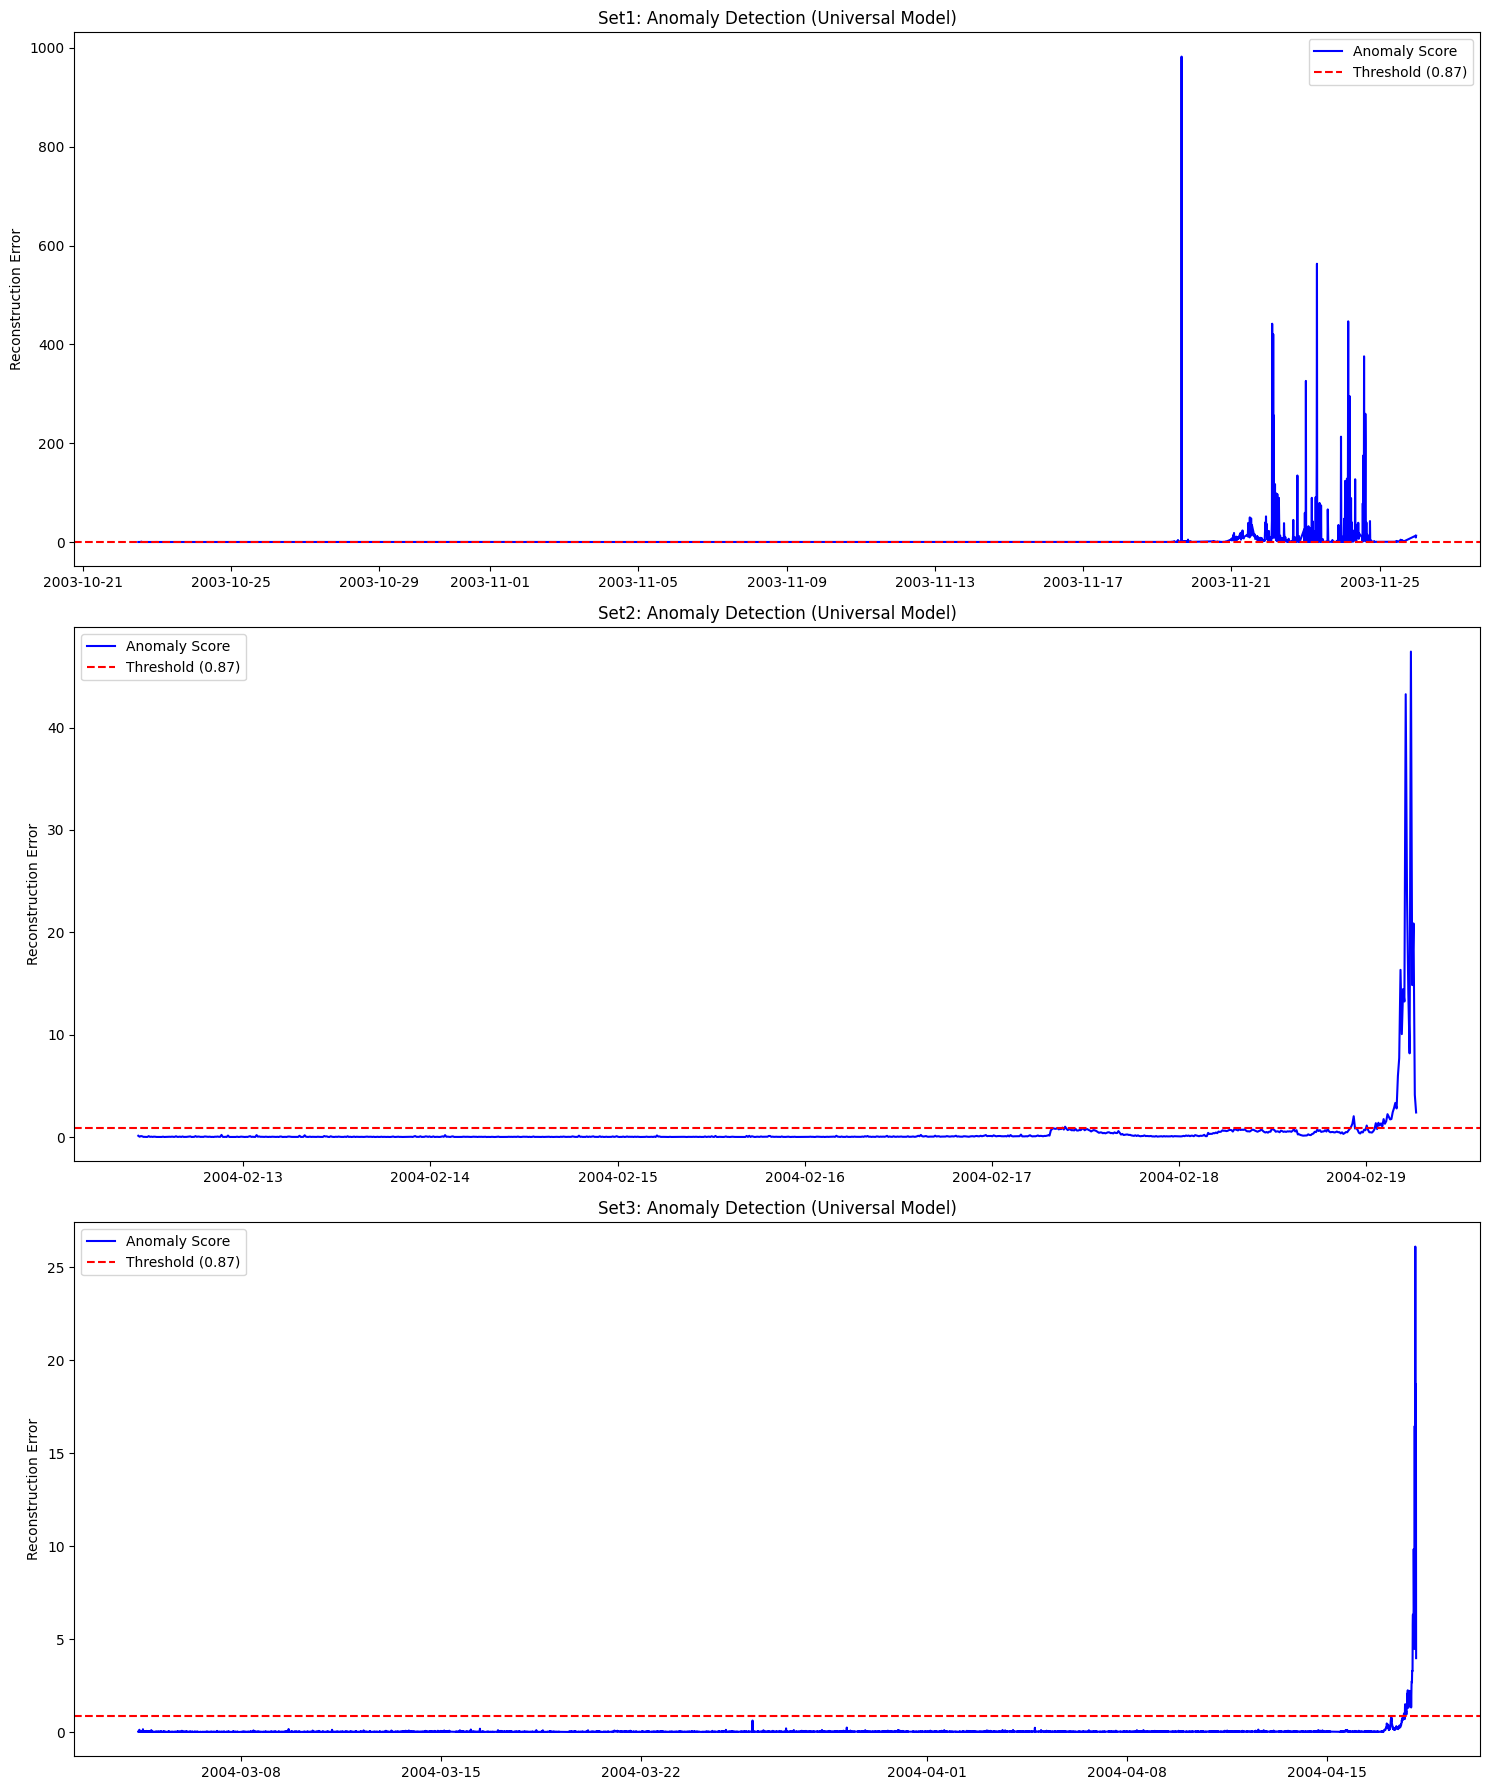

In [9]:
# Create a plot with 3 subplots (one for each dataset)
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Store results to use for Root Cause Analysis later
results = {}

for i, (set_name, df_test) in enumerate(all_data.items()):
    ax = axes[i]
    
    # Prepare Test Data
    X_test = df_test.drop(columns=['dataset'])
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate Anomaly Score
    X_recon = pca.inverse_transform(pca.transform(X_test_scaled))
    mse_score = np.mean(np.square(X_test_scaled - X_recon), axis=1)
    
    # Save for later
    results[set_name] = mse_score
    
    # Plot
    ax.plot(df_test.index, mse_score, label='Anomaly Score', color='blue')
    ax.axhline(safe_threshold, color='red', linestyle='--', label=f'Threshold ({safe_threshold:.2f})')
    
    # Styling
    ax.set_title(f"{set_name}: Anomaly Detection (Universal Model)")
    ax.set_ylabel("Reconstruction Error")
    ax.legend()

plt.tight_layout()
plt.show()


--- Root Cause Analysis for Set1 ---
Peak Anomaly Detected on: 2003-11-19 15:46:07
Top 5 Contributors to Failure:
        Feature         Error
16  B4_kurtosis  15574.574874
19     B4_crest    654.387956
6   B2_kurtosis    514.983465
0        B1_rms    439.716727
18      B4_peak    388.187302


C:\Users\MG\AppData\Local\Temp\ipykernel_8980\603839068.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Error', y='Feature', data=contribution_df, palette='Reds_r')


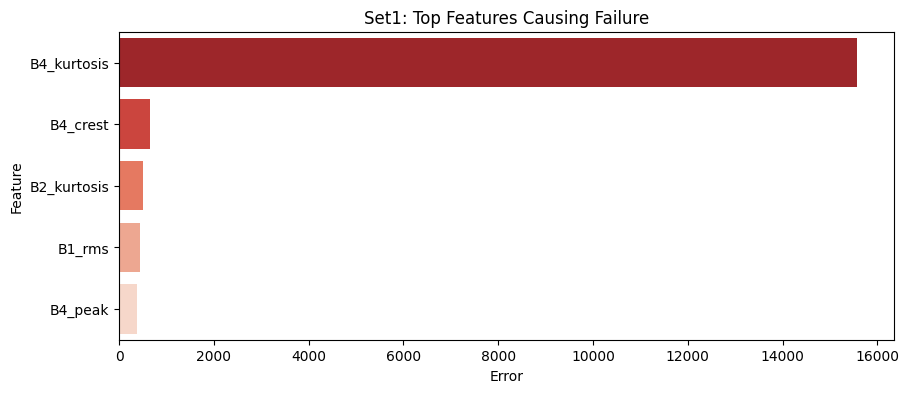


--- Root Cause Analysis for Set2 ---
Peak Anomaly Detected on: 2004-02-19 05:42:39
Top 5 Contributors to Failure:
        Feature       Error
3       B1_peak  323.159720
0        B1_rms  211.666629
7       B2_skew  182.758688
4      B1_crest   97.484502
16  B4_kurtosis   64.592812


C:\Users\MG\AppData\Local\Temp\ipykernel_8980\603839068.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Error', y='Feature', data=contribution_df, palette='Reds_r')


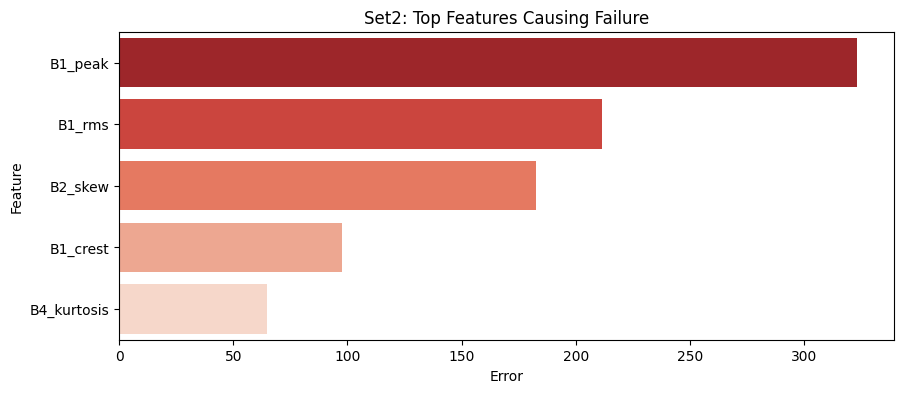


--- Root Cause Analysis for Set3 ---
Peak Anomaly Detected on: 2004-04-18 02:02:55
Top 5 Contributors to Failure:
        Feature       Error
14     B3_crest  281.610721
11  B3_kurtosis  191.003524
7       B2_skew   15.828605
16  B4_kurtosis    8.882635
13      B3_peak    4.650830


C:\Users\MG\AppData\Local\Temp\ipykernel_8980\603839068.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Error', y='Feature', data=contribution_df, palette='Reds_r')


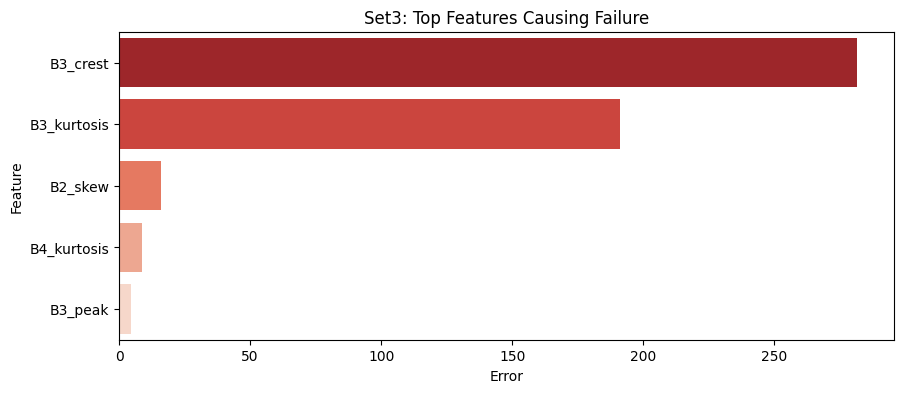

In [10]:
import seaborn as sns

def analyze_root_cause(set_name, df_test, model, scaler):
    print(f"\n--- Root Cause Analysis for {set_name} ---")
    
    # 1. Find the moment of highest error (The peak failure)
    X_test = df_test.drop(columns=['dataset'])
    X_test_scaled = scaler.transform(X_test)
    
    X_recon = model.inverse_transform(model.transform(X_test_scaled))
    mse_per_row = np.mean(np.square(X_test_scaled - X_recon), axis=1)
    
    # Get index of the worst anomaly
    worst_index = np.argmax(mse_per_row)
    worst_date = df_test.index[worst_index]
    print(f"Peak Anomaly Detected on: {worst_date}")
    
    # 2. Calculate contribution of each feature to that error
    # (Input - Output)^2 for that specific row
    row_scaled = X_test_scaled[worst_index]
    row_recon = X_recon[worst_index]
    error_per_feature = np.square(row_scaled - row_recon)
    
    # 3. Organize into a table
    feature_names = X_test.columns
    contribution_df = pd.DataFrame({'Feature': feature_names, 'Error': error_per_feature})
    contribution_df = contribution_df.sort_values('Error', ascending=False).head(5)
    
    print("Top 5 Contributors to Failure:")
    print(contribution_df)
    
    # 4. Simple Plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Error', y='Feature', data=contribution_df, palette='Reds_r')
    plt.title(f'{set_name}: Top Features Causing Failure')
    plt.show()

# Run for all sets
for set_name in all_data.keys():
    analyze_root_cause(set_name, all_data[set_name], pca, scaler)

In [11]:
import joblib

universal_package = {
    'model': pca,                 # The PCA trained on Set 1+2+3
    'scaler': scaler,             # The Scaler fitted on Set 1+2+3
    'threshold': safe_threshold   # The Universal Threshold (0.8686)
}

joblib.dump(universal_package, 'universal_bearing_model.joblib')

print("Success: 'universal_bearing_model.joblib' has been saved.")
print(f"  Threshold stored: {safe_threshold:.4f}")
print(f"  Components: {pca.n_components_}")

Success: 'universal_bearing_model.joblib' has been saved.
  Threshold stored: 0.8686
  Components: 10
